In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("./input"))

# from subprocess import check_output
# print(check_output(["ls", "./input"]).decode("utf8"))

['bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv']


In [21]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


data = pd.read_csv('./input/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv', parse_dates=[0], date_parser=dateparse)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1068258163.py:7: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273377 entries, 0 to 3273376
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   Timestamp          datetime64[ns, UTC]
 1   Open               float64            
 2   High               float64            
 3   Low                float64            
 4   Close              float64            
 5   Volume_(BTC)       float64            
 6   Volume_(Currency)  float64            
 7   Weighted_Price     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 199.8 MB


In [23]:
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 14:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 14:53:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,2011-12-31 14:54:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,2011-12-31 14:55:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,2011-12-31 14:56:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [24]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

data.head()

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2941466901.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2941466901.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 14:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 14:53:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,2011-12-31 14:54:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,2011-12-31 14:55:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,2011-12-31 14:56:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [25]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-05 00:00:00+00:00,317.66,317.67,317.66,317.67,0.500000,158.831853,317.663706
1,2015-01-12 00:00:00+00:00,272.45,305.00,272.45,291.10,175.837078,50502.066285,287.209426
2,2015-01-19 00:00:00+00:00,271.49,271.49,270.79,271.33,42.757775,11587.881189,271.012261
3,2015-01-26 00:00:00+00:00,212.21,212.21,212.21,212.21,10.000000,2122.100000,212.210000
4,2015-02-02 00:00:00+00:00,271.75,271.75,270.11,270.11,55.007325,14887.524494,270.646217


In [26]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Weighted_Price'].astype(float),
    mode = 'lines',
    name = 'Weighted Avg'
)

layout = dict(
    title='Historical Bitcoin Prices (2015-2018) with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [27]:
trace1 = go.Scatter(
    x = weekly_rows['Timestamp'],
    y = weekly_rows['Volume_(Currency)'].astype(float),
    mode = 'lines',
    name = 'Bitcoin Price (Open)'
)

layout = dict(
    title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [28]:
#BTC Volume vs USD visualization
trace = go.Scattergl(
    y = weekly_rows['Volume_(BTC)'].astype(float),
    x = weekly_rows['Weighted_Price'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
 xaxis=dict(
        title=dict(
            text='Weighted Price',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=dict(  # ✅ Định nghĩa đúng cho trục Y
        title=dict(
            text='Volume BTC',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')

In [29]:
#load the dataset 
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2083607725.py:2: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2083607725.py:4: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2083607725.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the orig

In [30]:
data.shape

(27212, 1)

In [31]:
# split data
split_date = '25-Jun-2017'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [32]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

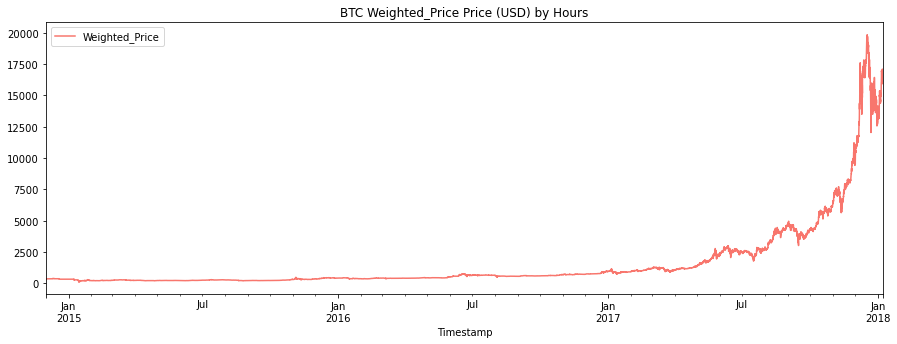

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

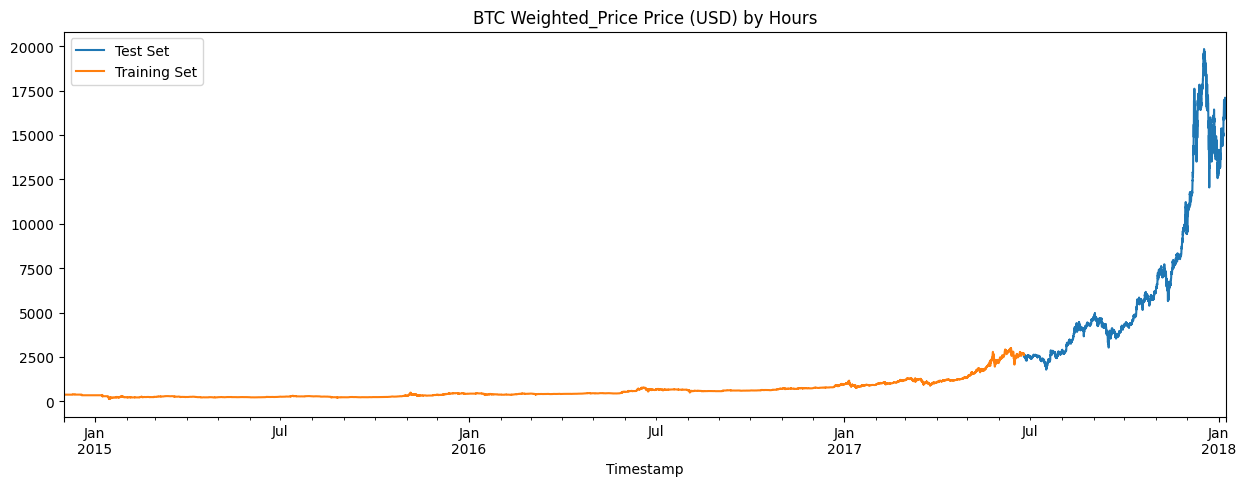

In [33]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [34]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

C:\Users\minhp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
450/450 - 2s - 6ms/step - loss: 0.0427
Epoch 2/100
450/450 - 1s - 2ms/step - loss: 0.0172
Epoch 3/100
450/450 - 1s - 2ms/step - loss: 0.0098
Epoch 4/100
450/450 - 1s - 3ms/step - loss: 0.0069
Epoch 5/100
450/450 - 1s - 3ms/step - loss: 0.0052
Epoch 6/100
450/450 - 1s - 3ms/step - loss: 0.0042
Epoch 7/100
450/450 - 1s - 2ms/step - loss: 0.0035
Epoch 8/100
450/450 - 1s - 2ms/step - loss: 0.0030
Epoch 9/100
450/450 - 1s - 2ms/step - loss: 0.0026
Epoch 10/100
450/450 - 1s - 3ms/step - loss: 0.0023
Epoch 11/100
450/450 - 1s - 2ms/step - loss: 0.0020
Epoch 12/100
450/450 - 1s - 2ms/step - loss: 0.0018
Epoch 13/100
450/450 - 1s - 2ms/step - loss: 0.0016
Epoch 14/100
450/450 - 1s - 3ms/step - loss: 0.0015
Epoch 15/100
450/450 - 1s - 2ms/step - loss: 0.0013
Epoch 16/100
450/450 - 1s - 2ms/step - loss: 0.0012
Epoch 17/100
450/450 - 1s - 2ms/step - loss: 0.0011
Epoch 18/100
450/450 - 1s - 2ms/step - loss: 0.0010
Epoch 19/100
450/450 - 1s - 2ms/step - loss: 9.5844e-04
Epoch 20/100
450/

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

In [36]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [37]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

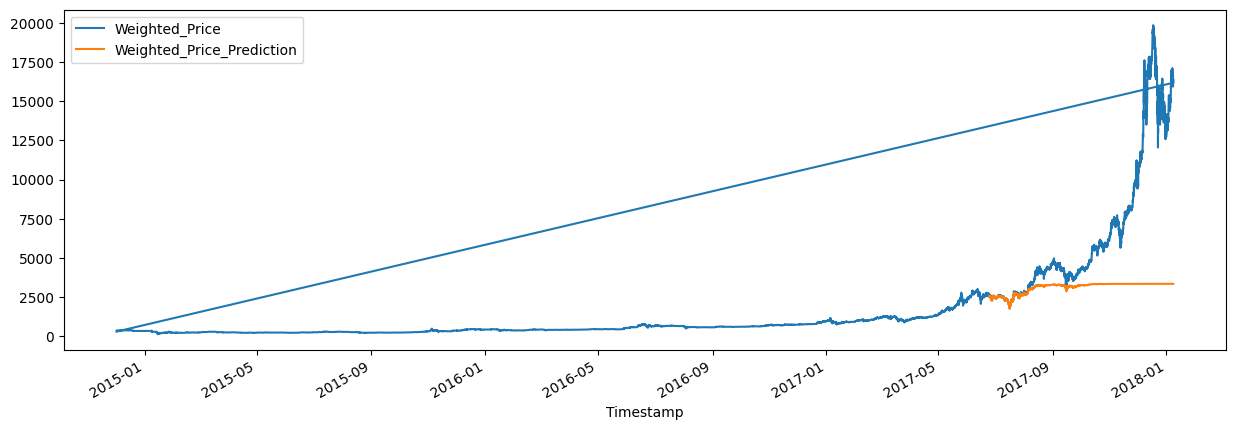

In [38]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

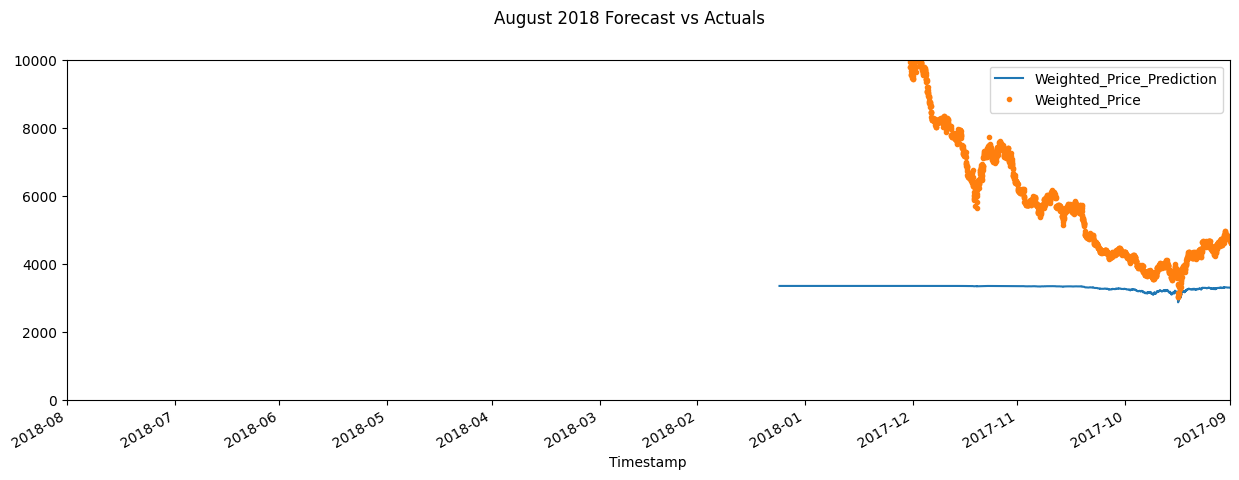

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

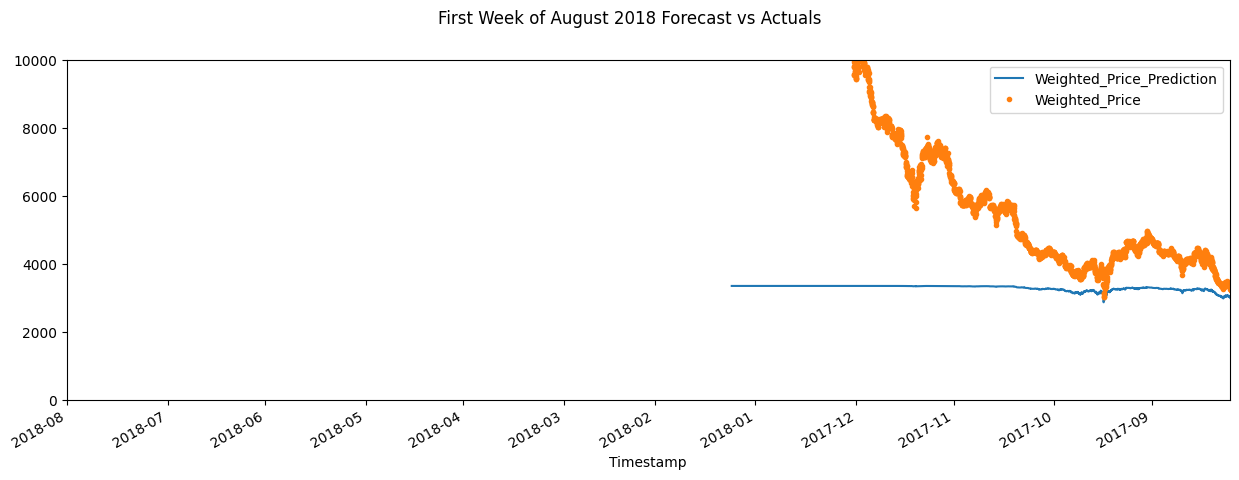

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [41]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

31804441.23354963

In [42]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

3509.301994489832

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

C:\Users\minhp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [77]:
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:3: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the orig

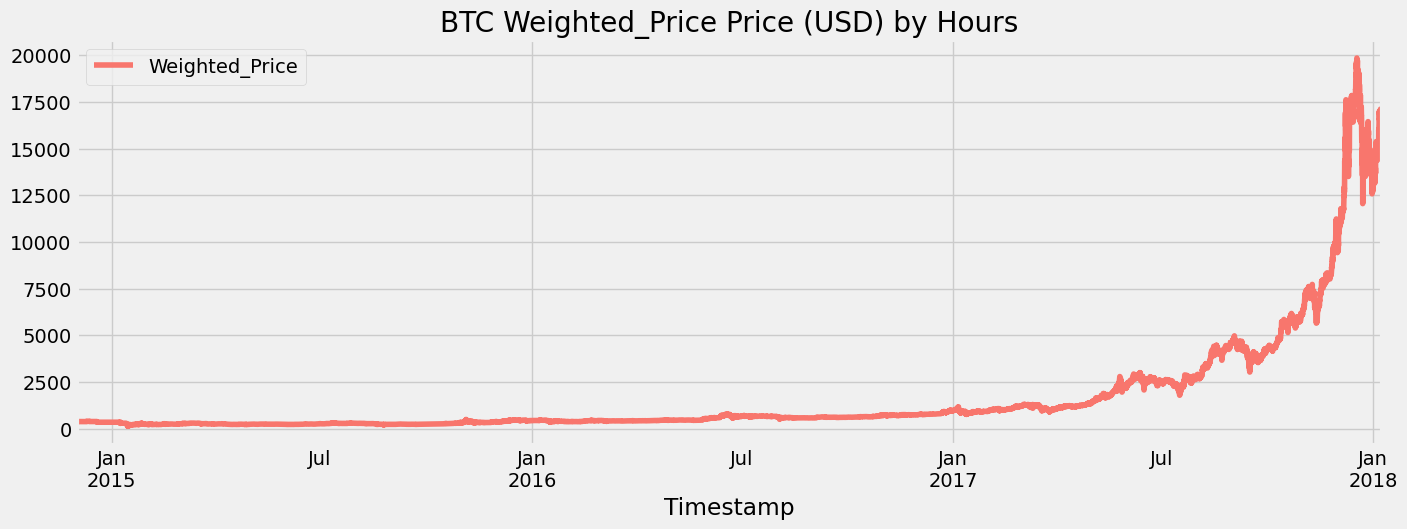

In [78]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [79]:
split_date = '25-Jun-2017'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

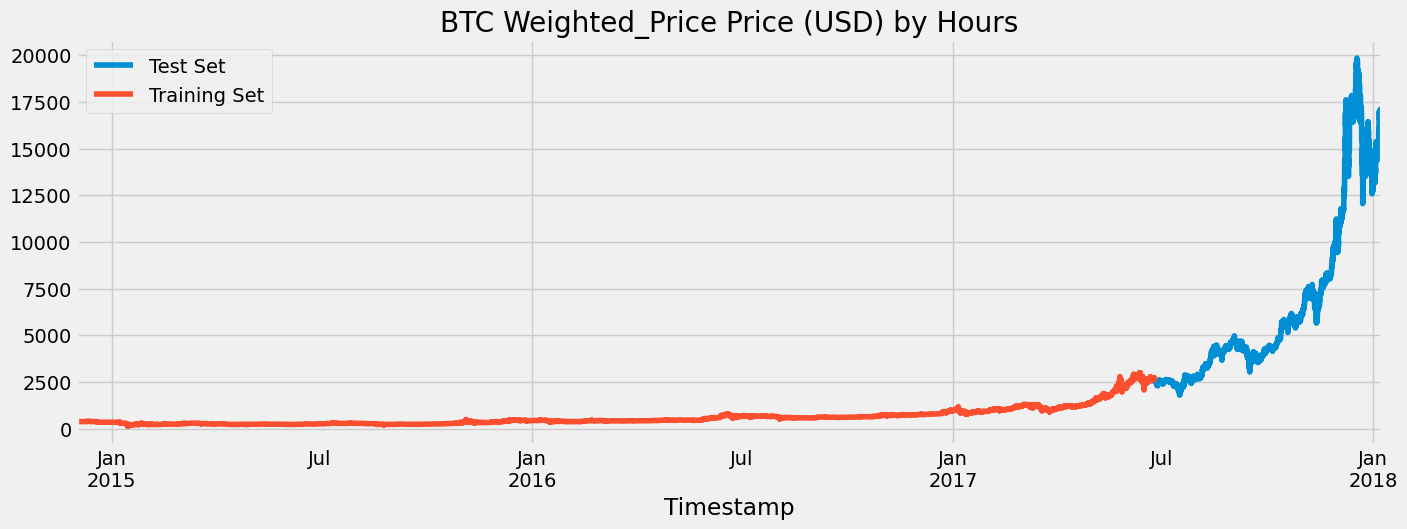

In [80]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [81]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [82]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

In [83]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False) # Change verbose to True if you want to see it train

C:\Users\minhp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning:

[10:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [84]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

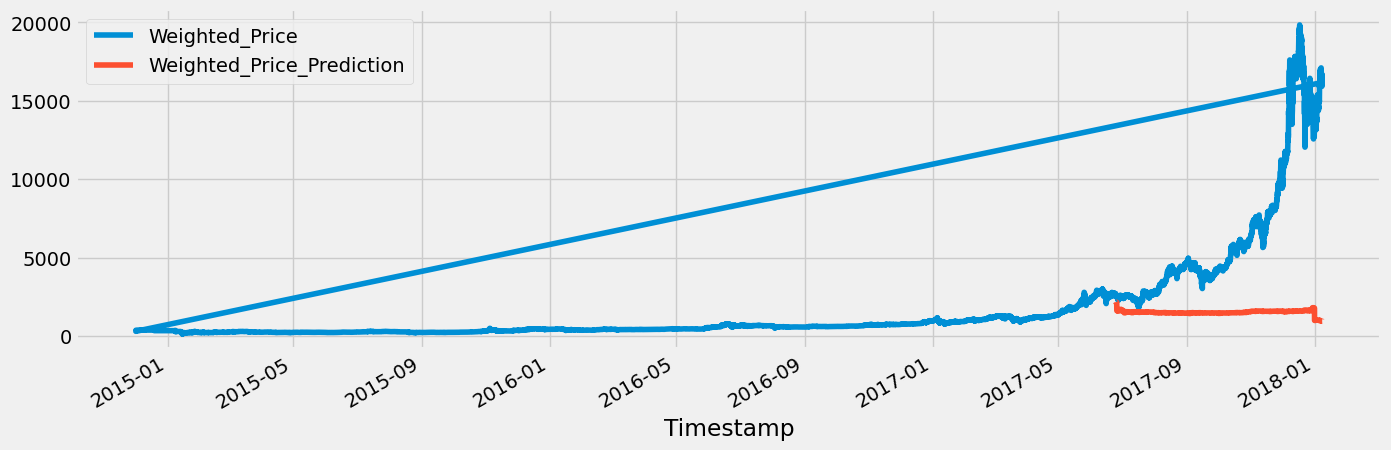

In [85]:
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))

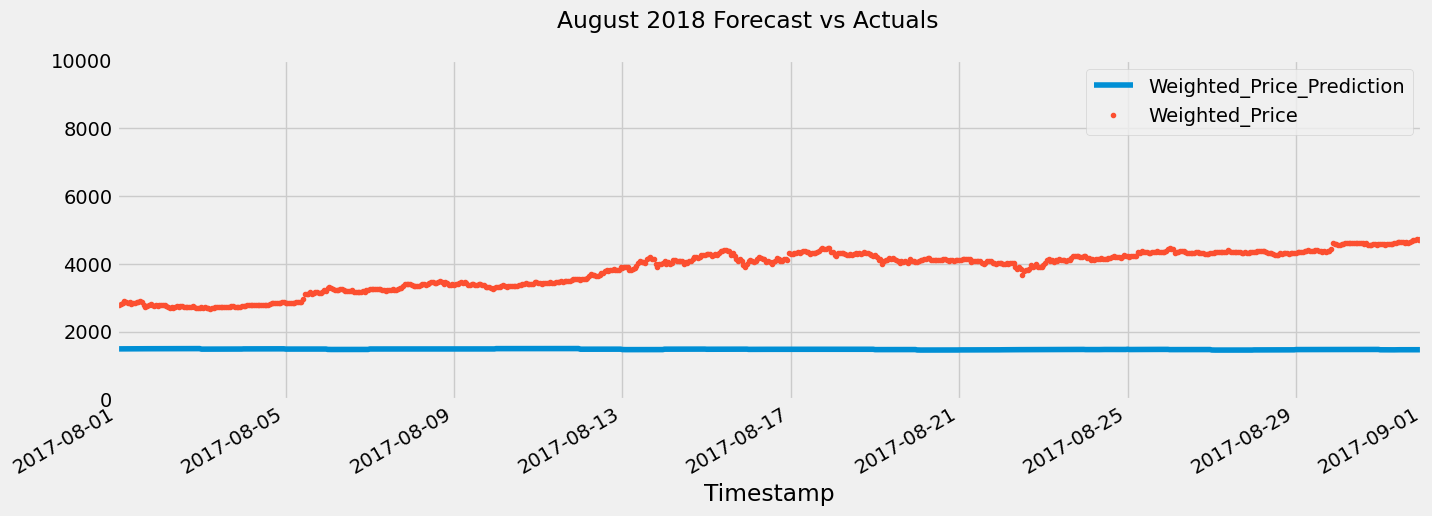

In [86]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2017', upper='09-01-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

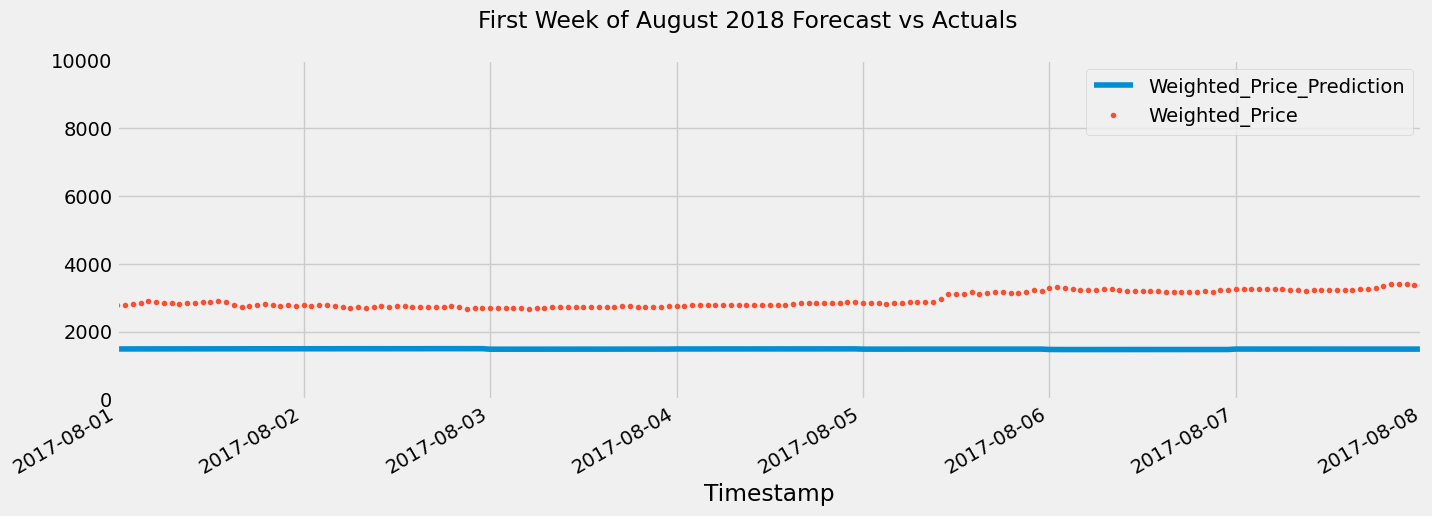

In [87]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2017', upper='08-08-2017')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

In [88]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

47335573.24885449

In [89]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

5114.607478140918

In [90]:
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')
data = data[['Weighted_Price']]
data['Weighted_Price'].fillna(method='ffill', inplace=True)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:3: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\1493241207.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the orig

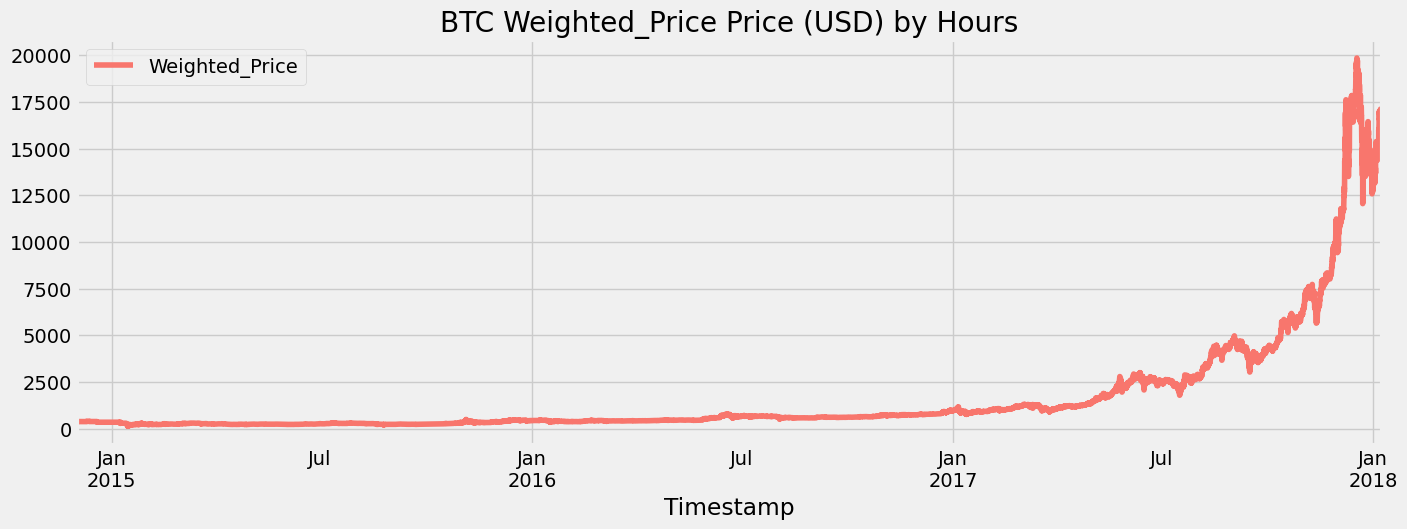

In [91]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

In [92]:
split_date = '25-Jun-2017'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

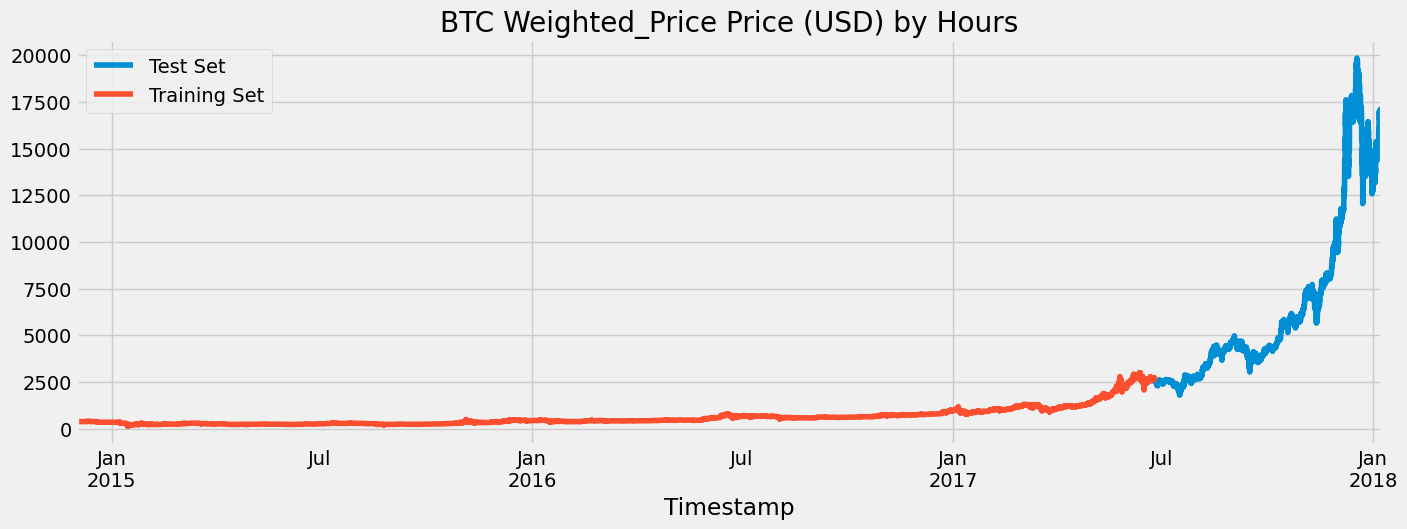

In [93]:
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [94]:
data_train = data_train.reset_index().rename(columns={'Timestamp':'ds', 'Weighted_Price':'y'})

In [95]:
# Setup and train model
model = Prophet()
model.fit(data_train)

10:11:00 - cmdstanpy - INFO - Chain [1] start processing
10:11:31 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
print(data_test.head())


                     Weighted_Price
Timestamp                          
2017-06-25 01:00:00     2628.027031
2017-06-25 02:00:00     2569.445684
2017-06-25 03:00:00     2513.665503
2017-06-25 04:00:00     2577.636300
2017-06-25 05:00:00     2588.482712


In [122]:
# Predict on training set with model
data_test_fcst = model.predict(df=data_test.reset_index().rename(columns={'Timestamp':'ds'}))

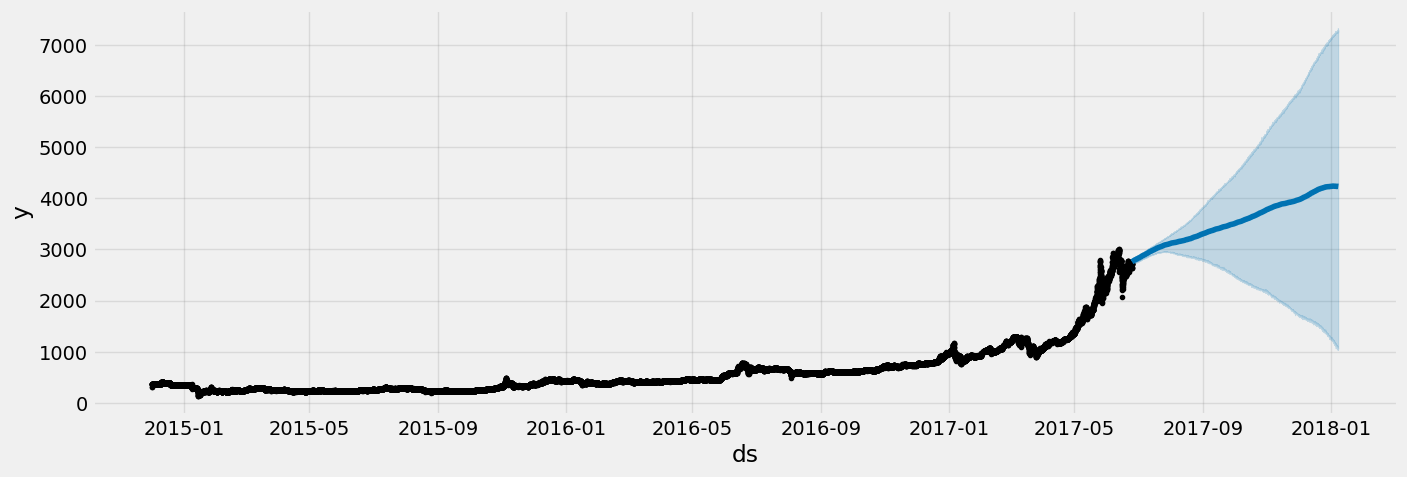

In [123]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)

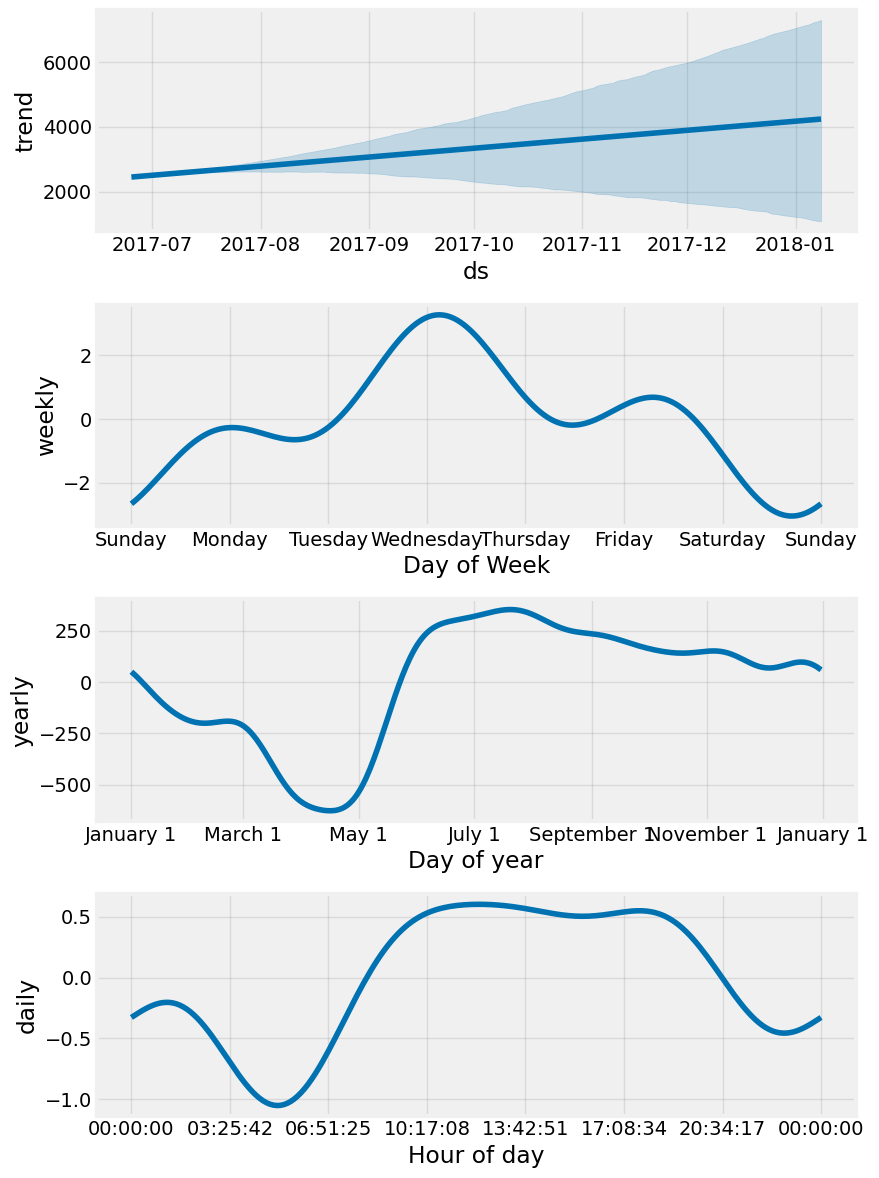

In [124]:
# Plot the components
fig = model.plot_components(data_test_fcst)

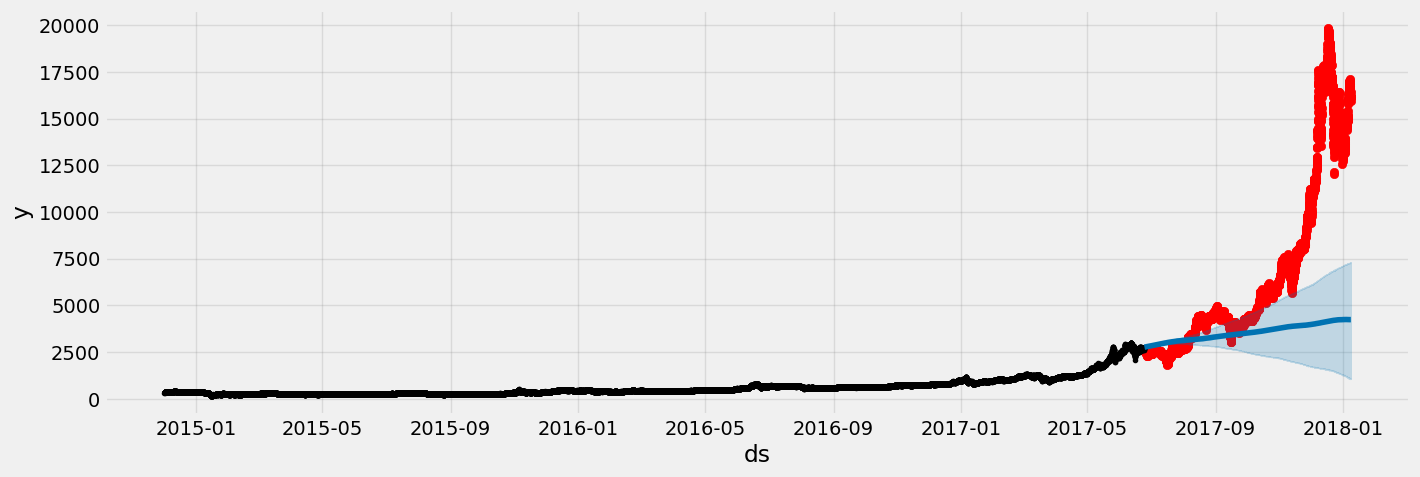

In [125]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

In [126]:
data_all.head()

,Timestamp,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ds,y
0,2017-06-25 01:00:00,2450.672555,2694.690578,2820.735640,2450.672555,2450.672555,306.281793,306.281793,306.281793,-0.210017,...,-2.559106,309.050916,309.050916,309.050916,0.0,0.0,0.0,2756.954348,NaT,NaN
1,2017-06-25 02:00:00,2451.051721,2699.245038,2820.140169,2451.051721,2451.051721,306.410005,306.410005,306.410005,-0.272231,...,-2.442967,309.125203,309.125203,309.125203,0.0,0.0,0.0,2757.461727,NaT,NaN
2,2017-06-25 03:00:00,2451.430888,2699.476347,2818.725668,2451.430888,2451.430888,306.333737,306.333737,306.333737,-0.547030,...,-2.318787,309.199554,309.199554,309.199554,0.0,0.0,0.0,2757.764625,NaT,NaN
3,2017-06-25 04:00:00,2451.810055,2699.802637,2820.436947,2451.810055,2451.810055,306.203749,306.203749,306.203749,-0.882180,...,-2.188042,309.273971,309.273971,309.273971,0.0,0.0,0.0,2758.013804,NaT,NaN
4,2017-06-25 05:00:00,2452.189222,2693.534811,2824.710255,2452.189222,2452.189222,306.244771,306.244771,306.244771,-1.051428,...,-2.052256,309.348455,309.348455,309.348455,0.0,0.0,0.0,2758.433993,NaT,NaN


In [127]:
print(data_fcst.columns)
print(data_train.columns)
print(final_data.columns)  # nếu final_data đã có sẵn


Index(['Timestamp', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Index(['ds', 'y'], dtype='object')
Index(['Timestamp', 'trend_x', 'yhat_lower_x', 'yhat_upper_x', 'trend_lower_x',
       'trend_upper_x', 'additive_terms_x', 'additive_terms_lower_x',
       'additive_terms_upper_x', 'daily_x', 'daily_lower_x', 'daily_upper_x',
       'weekly_x', 'weekly_lower_x', 'weekly_upper_x', 'yearly_x',
       'yearly_lower_x', 'yearly_upper_x', 'multiplicative_terms_x',
       'multiplicative_terms_lower_x', 'multiplicative_terms_upper_x',
       'yhat_x', 'ds', 'y', 'trend_y', 'yhat_lower_y', 'yhat_upper_y',
       'trend_lower_y', 'trend_up

In [128]:
#for comparision of predictions
data_fcst = data_test_fcst
data_fcst = data_fcst.rename(columns={'ds': 'Timestamp'})
data_all = pd.concat([data_fcst, data_train], sort=False)
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'yhat': 'prophet'})
final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost','prophet']]

KeyError: "['Weighted_Price', 'lstm', 'xgboost'] not in index"

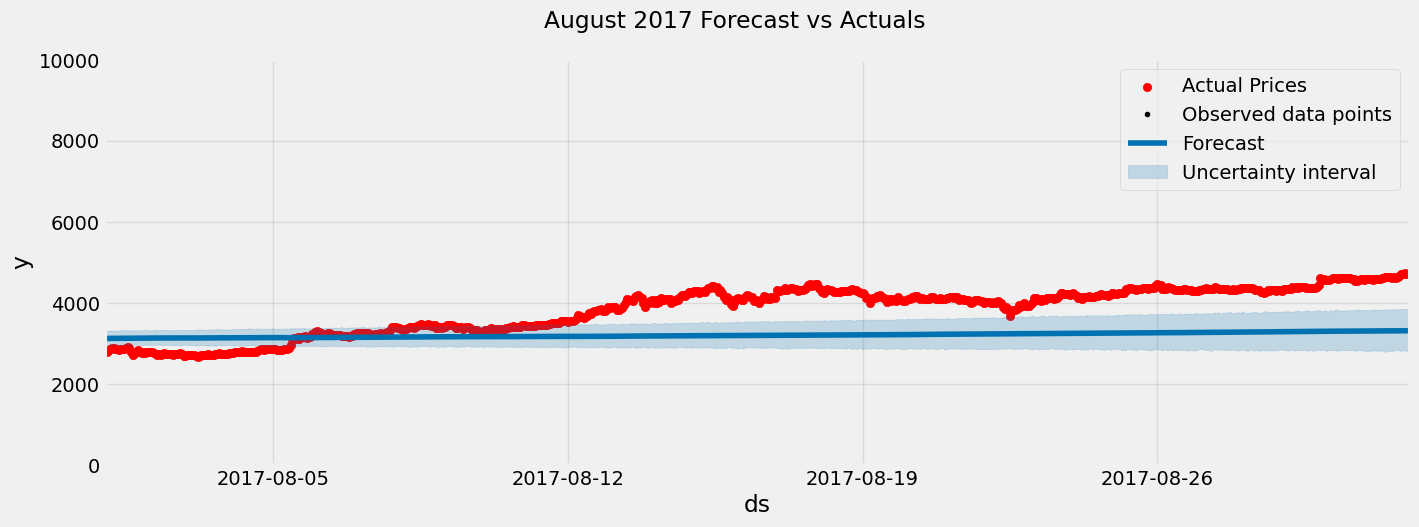

In [131]:
import matplotlib.pyplot as plt

# Chuyển đổi chuỗi ngày tháng thành datetime
lower_date = pd.to_datetime('2017-08-01')
upper_date = pd.to_datetime('2017-09-01')

# Vẽ biểu đồ
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Vẽ dữ liệu thực tế
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r', label='Actual Prices')

# Vẽ dự đoán của mô hình Prophet
fig = model.plot(data_test_fcst, ax=ax)

# Giới hạn trục X bằng datetime
ax.set_xlim(lower_date, upper_date)

# Giới hạn trục Y
ax.set_ylim(0, 10000)

# Tiêu đề biểu đồ
plt.suptitle('August 2017 Forecast vs Actuals')
plt.legend()
plt.show()


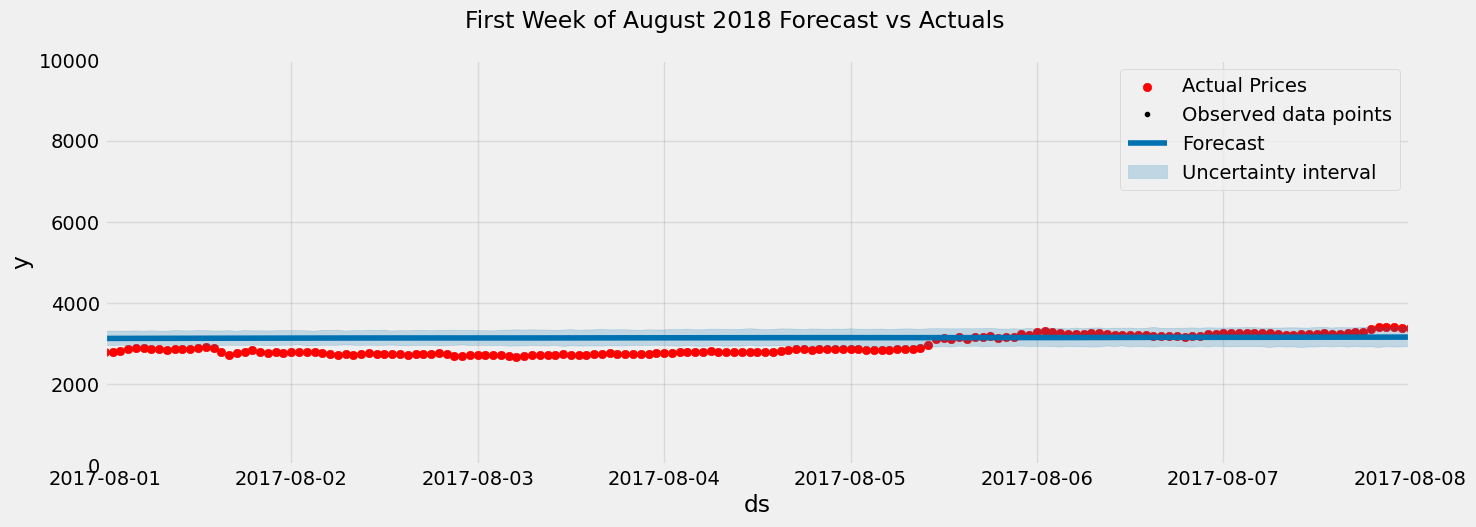

In [134]:
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển đổi giới hạn trục X từ string sang datetime
lower_date = pd.to_datetime('2017-08-01')
upper_date = pd.to_datetime('2017-08-08')

# Vẽ biểu đồ
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Vẽ dữ liệu thực tế
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r', label='Actual Prices')

# Vẽ dự đoán của mô hình Prophet
fig = model.plot(data_test_fcst, ax=ax)

# Giới hạn trục X với datetime
ax.set_xlim(lower_date, upper_date)

# Giới hạn trục Y
ax.set_ylim(0, 10000)

# Tiêu đề biểu đồ
plt.suptitle('First Week of August 2018 Forecast vs Actuals')
plt.legend()
plt.show()


In [135]:
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

27420904.862473134

In [136]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test_fcst['yhat'])

3278.71249408414

In [137]:
# Create traces
trace0 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Real Price'
)
trace1 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)
trace3 = go.Scatter(
    x = final_data['Timestamp'],
    y = final_data['prophet'],
    mode = 'lines+markers',
    name = 'Prophet Prediction'
)

# Edit the layout
layout = dict(title = 'Comparision of LSTM,XGBoost and Prophet',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

data = [trace0, trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

KeyError: 'Weighted_Price'

In [ ]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In [ ]:
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 

In [140]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In [141]:
data = pd.read_csv('./input/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv',parse_dates=[0], date_parser=dateparse) 

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\3729273410.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [142]:
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)
data['Weighted_Price'].fillna(method='ffill', inplace=True)
data['Volume_(BTC)'].fillna(method='ffill', inplace=True)
data['Volume_(Currency)'].fillna(method='ffill', inplace=True)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2979732711.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2979732711.py:1: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2979732711.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will c

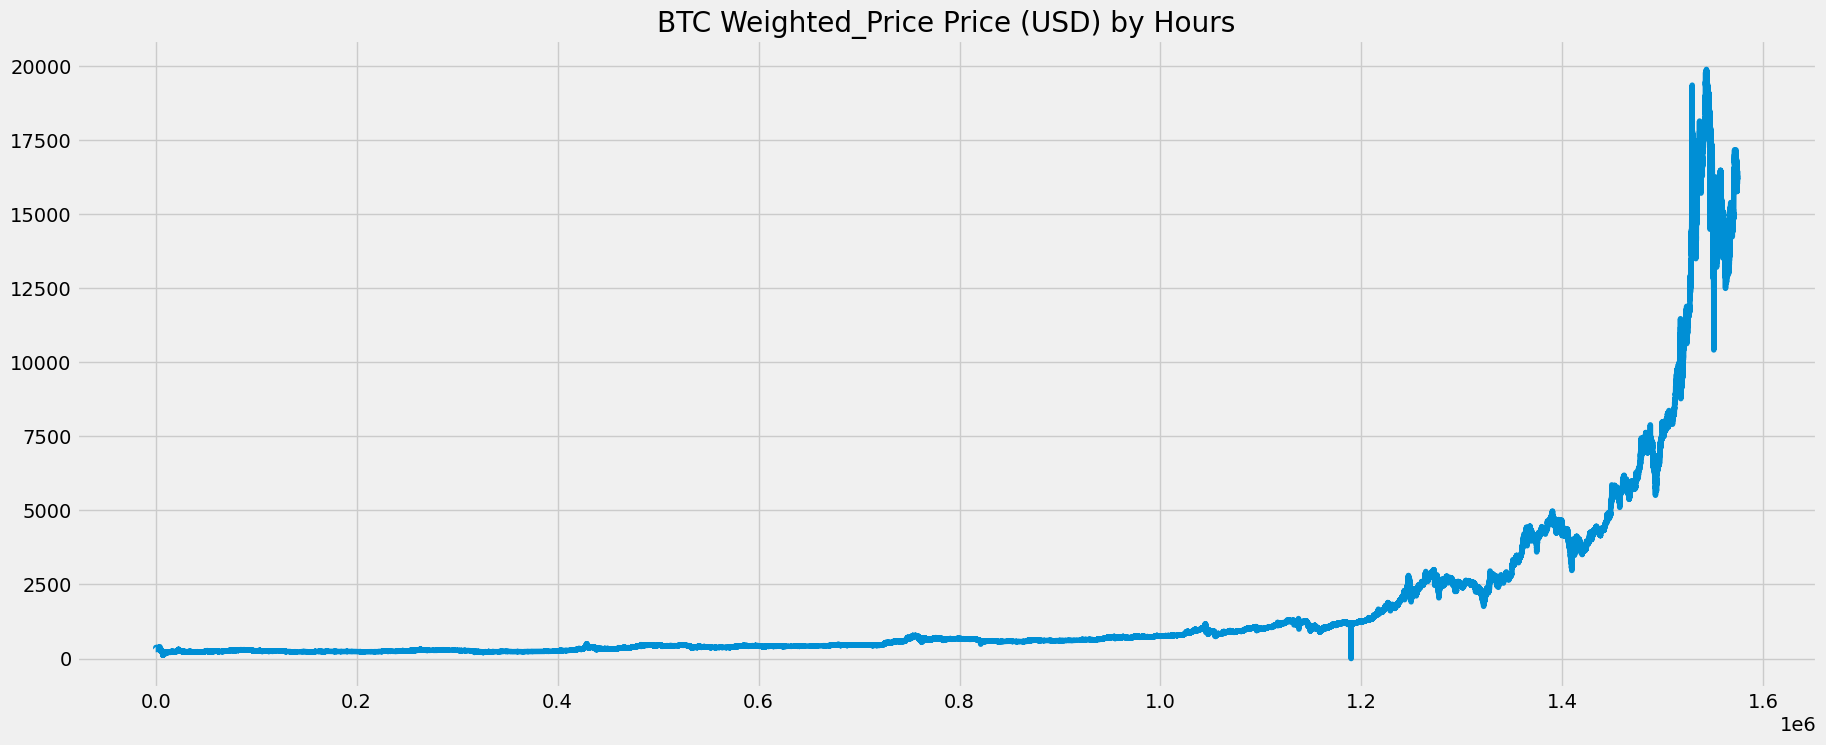

In [143]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Hours')
plt.plot(data.Weighted_Price, '-', label='By Hours')

In [144]:
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2488323866.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2488323866.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\minhp\AppData\Local\Temp\ipykernel_16740\2488323866.py:4: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



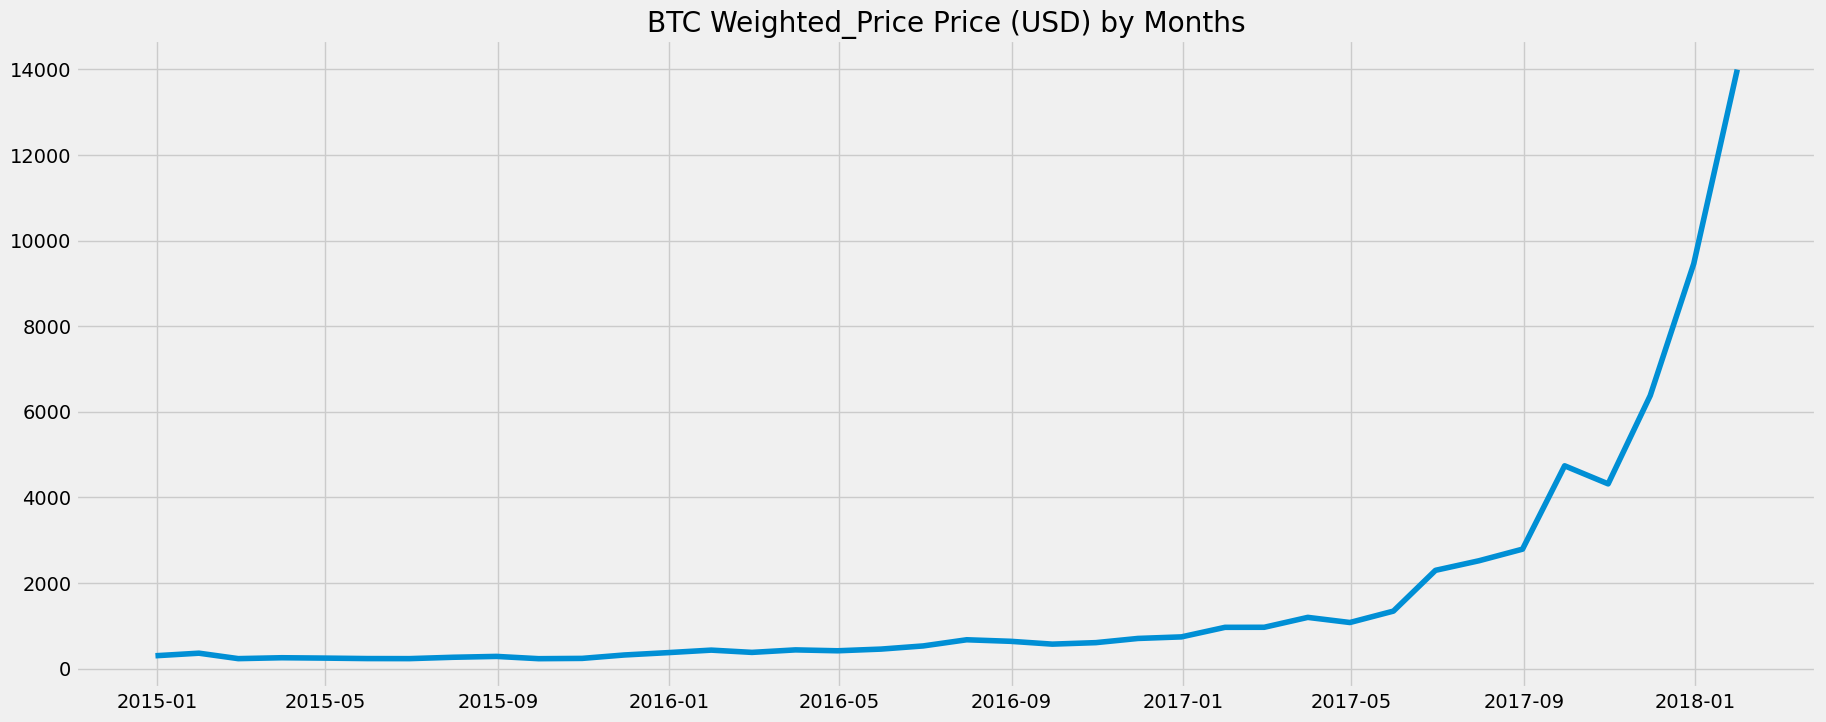

In [145]:
plt.figure(figsize=[20,8])
plt.title('BTC Weighted_Price Price (USD) by Months')
plt.plot(data.Weighted_Price, '-', label='By Months')

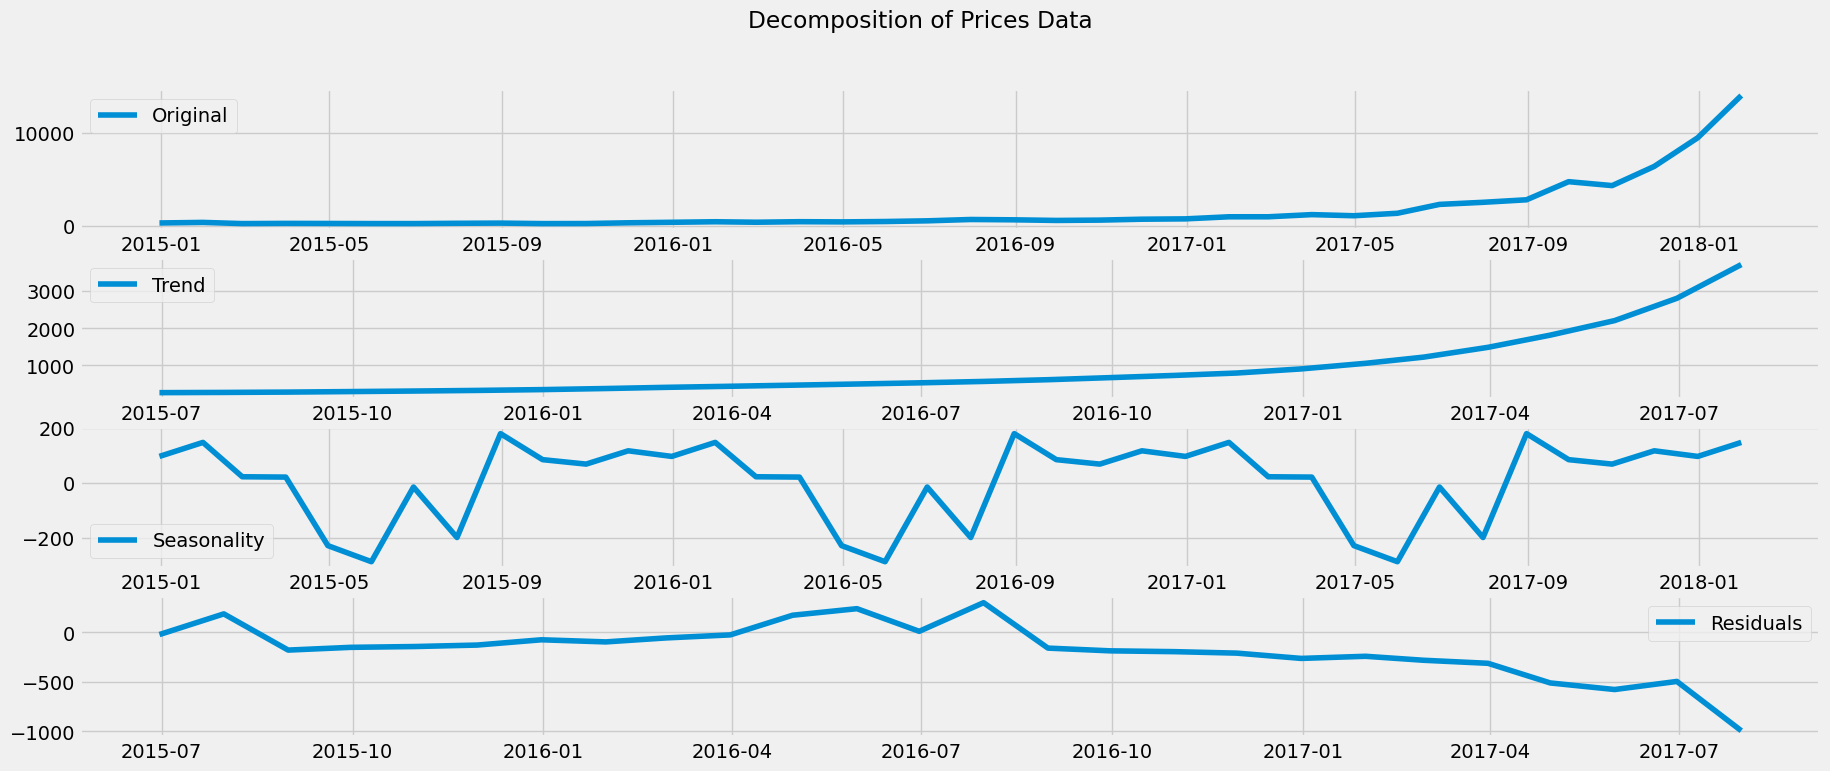

In [146]:
decomposition = sm.tsa.seasonal_decompose(data.Weighted_Price)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(data.Weighted_Price, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [147]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Weighted_Price)[1])

Dickey–Fuller test: p=0.929224


In [151]:
print(type(data['Weighted_Price']))  # Kiểu dữ liệu của cột
print(data['Weighted_Price'].shape)  # Kiểm tra số chiều của dữ liệu


<class 'pandas.core.series.Series'>
(38,)


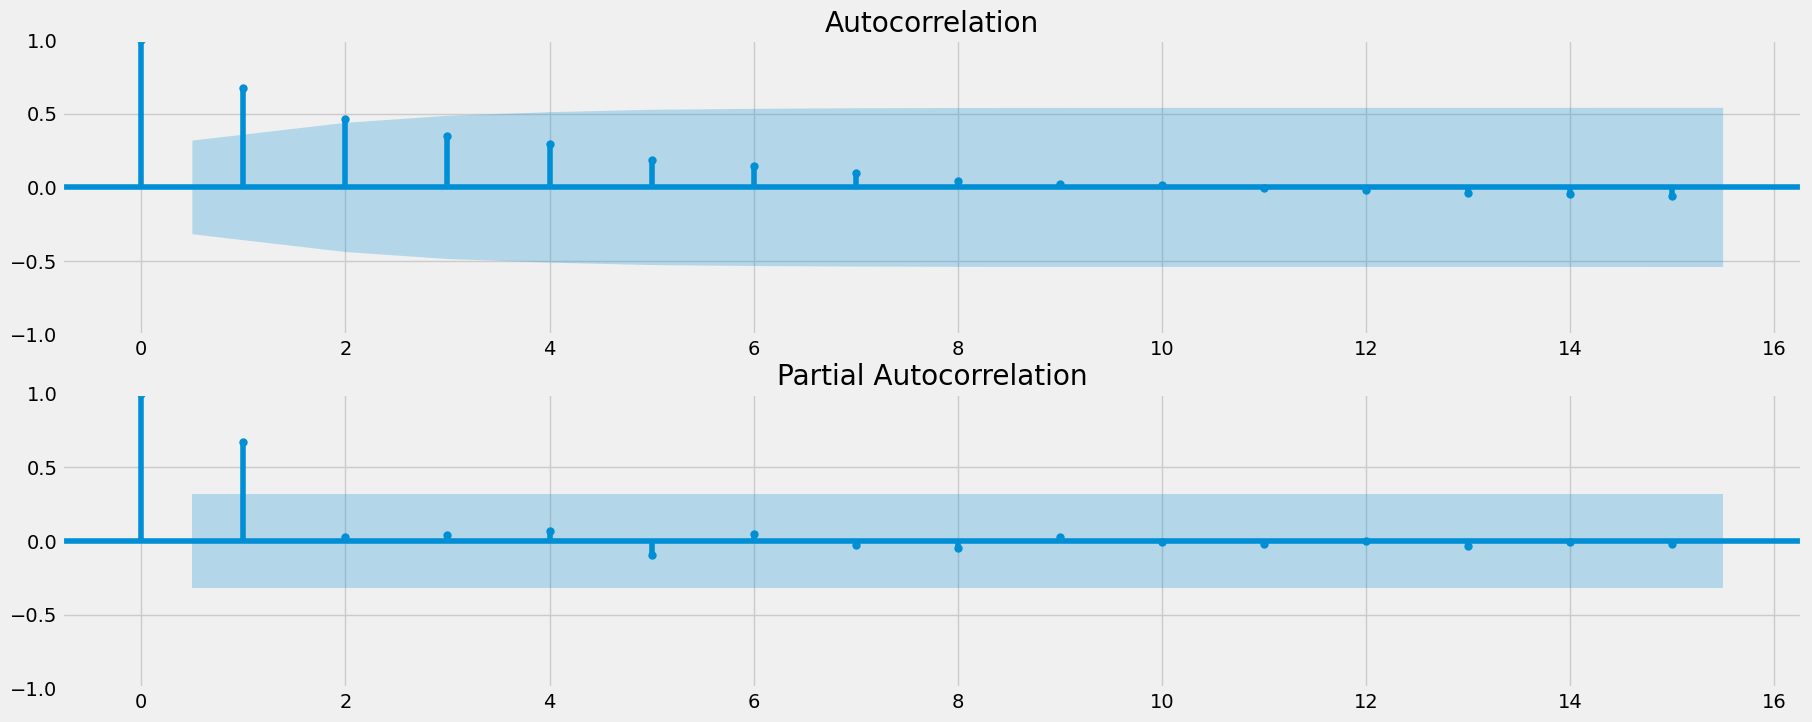

In [154]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(data.Weighted_Price, ax=pyplot.gca(),lags=15)
pyplot.subplot(212)
plot_pacf(data.Weighted_Price, ax=pyplot.gca(), lags=15)
pyplot.show()

In [155]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data.Weighted_Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [156]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters   aic
22  (1, 0, 2, 0)   8.0
28  (1, 1, 2, 0)  10.0
23  (1, 0, 2, 1)  10.0
40  (2, 0, 2, 0)  10.0
34  (1, 2, 2, 0)  12.0
                                     SARIMAX Results                                      
Dep. Variable:                     Weighted_Price   No. Observations:                   38
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                   0.000
Date:                            Sat, 15 Mar 2025   AIC                              8.000
Time:                                    10:29:59   BIC                               -inf
Sample:                                12-31-2014   HQIC                               nan
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

Dickey–Fuller test:: p=0.938600


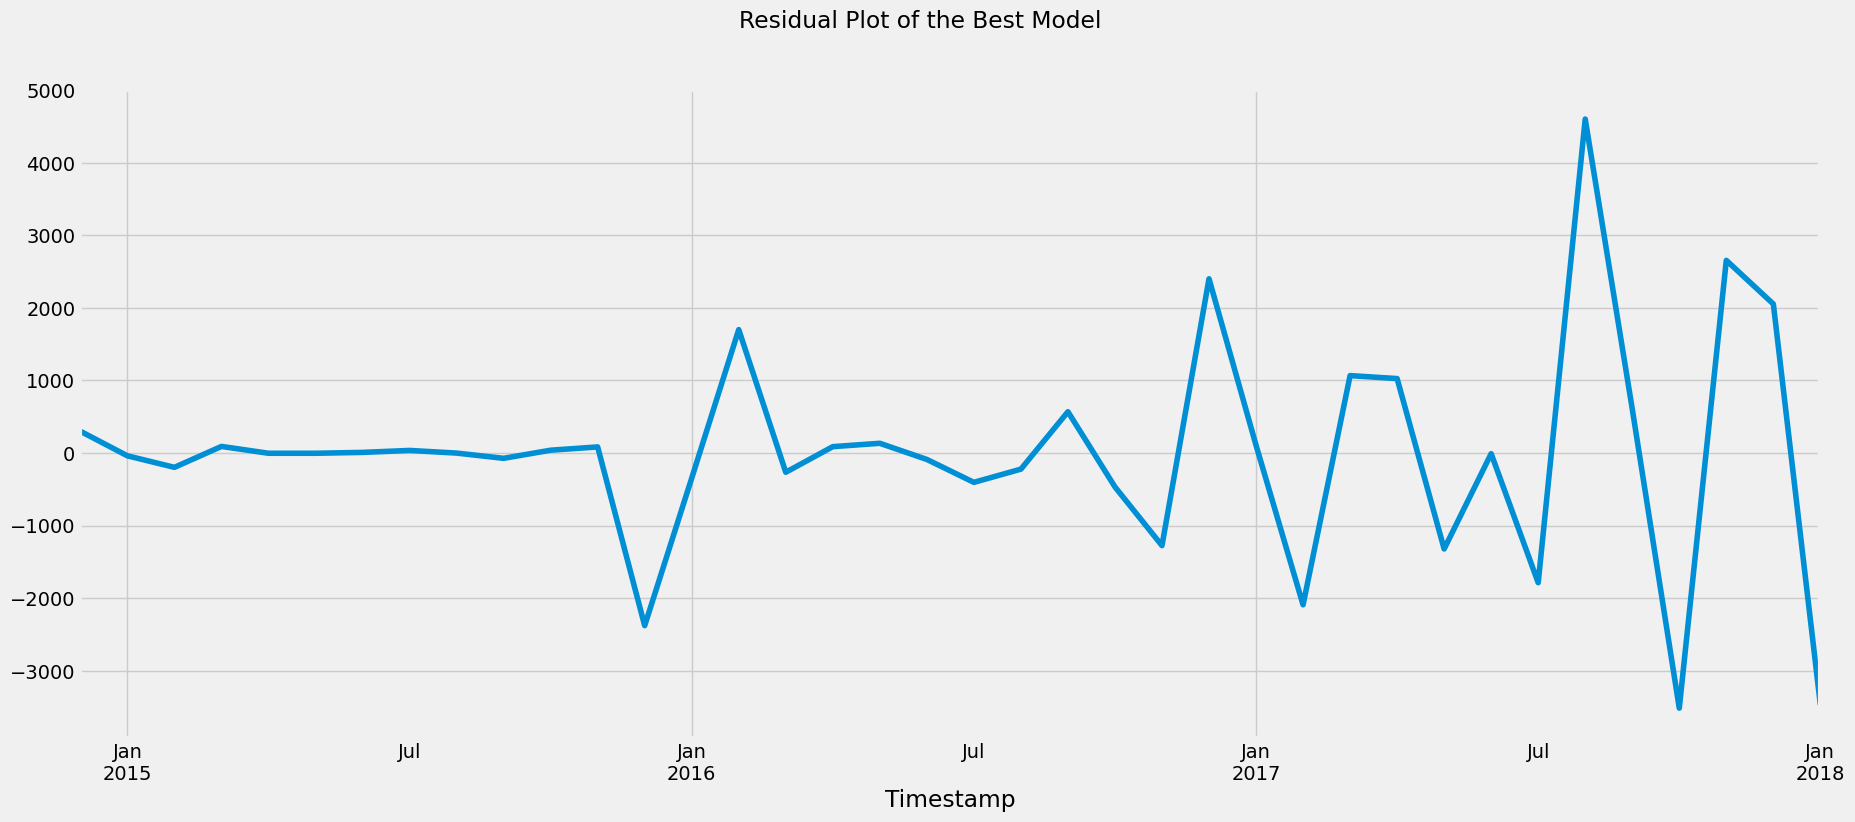

In [157]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

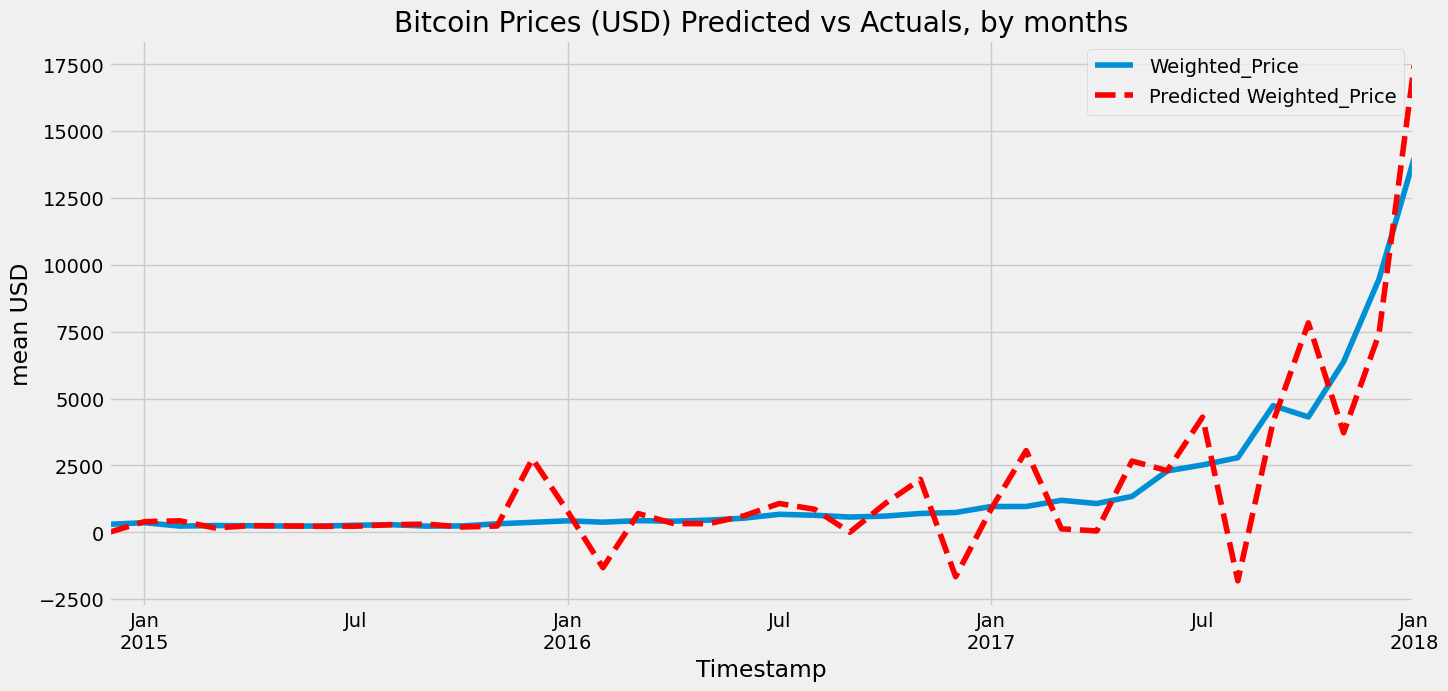

In [158]:
df_month2 = data[['Weighted_Price']]
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=200)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()